# QAOA Tutorial &#150; Code
---

Simple code to implement a QAOA circuit using Qiskit and optimize using some external optimizer, such as the ones provided by Scipy

Our goal will be to implement the circuit below with free parameters $\gamma_i$ and $\beta_i$, run an experiment with it and use the measurement results to optimize a given cost function by varying the parameters.

<image></image>

$H_C$ will be a Hamiltonian associated to the cost function, $H_M$ will be a Hamiltonian&#151;which we call the mixing Hamitonian&#151;for which we know its spectrum and eigenvector basis.

---

## Generic QUBO problem

For this first part we are going to solve a random instance of a **QUBO**<a name="QUBO_desc"></a>[<sup>1</sup>](#QUBO_desc) problem. That is, we will be looking for the optimal point of a quadratic function in **n** binary variables $x_i\,\in\,\{0,1\}$
without imposing any restriction over them.


The problem is an optimization problem stated as
$$ \max_{x_i \in \{0,1\}} C(x_1,\ldots,x_n)$$
where $C$ is a function that has the general form
$$C(x_1,\ldots,x_n) = \sum_{i,j=1}^n Q_{ij}\,x_i x_j + \sum_i^n L_i\, x_i, $$
with possible simplifications coming from the fact that $x_i x_j = x_j x_i$ and that, for binary variables, $x_i^2 = x_i$.


In the problem below we will produce random coefficients $Q_{ij}$ and $L_i$ and later map the classical form into its quantum version. More explanation is provided below as the code is provided. 

<a name="QUBO_desc"></a><sup>1</sup> from *Quadratic Unconstrained Binary Optimization* [^](#QUBO_desc)

---
### Preamble:

In [44]:
import numpy as np
import itertools as it
from scipy.optimize import minimize

# Qiskit modules
import qiskit
from qiskit import Aer, QuantumCircuit, execute, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter, ParameterVector

---
In the code **nvar** will correspond to the number of variables <br>
**c_quad** and **c_lin** will correspond to the quadratic coefficients $Q_{ij}$ and linear coefficients $L_i$ respectively. 

To simplify the quantum implementation later, we will eliminate redundancies by setting $Q_{ij} = (\,Q^0_{ij} + Q^0_{ji}\,)/2$ for $i < j$, and $Q_{ij} = 0$ for $j \leq i$,<br> where $Q^0_{ij}$ are the initial coefficients obtained randomly.

Similarly, we will set $L_i = L^0_i + Q^0_{ii}$, where $L^0_i$ are the generated linear coefficients.

Since the initial coefficients are random, we could also generate them without the redundancies from the start, but this treatment will be useful if we wish to use specific coefficients later instead.

In [45]:
# Number of binary variables == Number of Qubits
nvar = 4

# Generating the initial coefficients (Q^0_ij, L^0_i)
c_lin = np.random.randint(-4, 5, size=(nvar, ))   
c_quad = np.random.randint(-4, 5, size=(nvar, nvar))

# Eliminating redundancies
c_lin += np.diag(c_quad)   # L_i = L^0_i + Q^0_ii 

c_quad = 0.5*(c_quad + c_quad.T) # Symmetrizing Q
for i in range(nvar):
    for j in range(0,i+1):
        # Eliminating terms with j <= i
        c_quad[i,j] = 0


### Brute force optimization
Since we are dealing with small-sized problems, we can optimize them classically through brute force search for the optimum.

We will solve in this way before mapping the problem to its quantum version to obtain the possible solutions and target values.

In [46]:
# Variable with the optimal value found
opt_brute = -np.inf

# Running through all values of x_1,...,x_n
# itertools.product produce the cartesian product of the arguments passed
# Useful when used with range() to loop through all values for multiple variables
print('Results:')
for X in it.product(range(2), repeat=nvar):
    X_str = [str(x) for x in X]
    X_var = np.array(X)
    tmp_C = X_var@c_quad@X_var + c_lin@X_var
    
    print(f"  {''.join(X_str)}: {tmp_C}")
    
    if tmp_C > opt_brute:
        opt_brute = tmp_C                
        opt_seq = [''.join(X_str)]
        
    elif tmp_C == opt_brute:
        opt_seq = opt_seq.append(''.join(X_str))

print(f'\nOptimal value: {opt_brute}')
print(f"Optimal sequences: {'; '.join([s for s in opt_seq])}")

Results:
  0000: 0.0
  0001: 3.0
  0010: 1.0
  0011: 7.0
  0100: -7.0
  0101: -2.0
  0110: -8.0
  0111: 0.0
  1000: 3.0
  1001: 5.5
  1010: 4.5
  1011: 10.0
  1100: -3.5
  1101: 1.0
  1110: -4.0
  1111: 3.5

Optimal value: 10.0
Optimal sequences: 1011


---
### Quantum implementation &ndash; Explicit form

We will now make the conversion of $C$ into its quantum version, represented by the hamiltonian $H_C$.

In this part we will implement all parts explicitly. First we will build the unitaries $U_C(\gamma) = \exp(-i \gamma H_C)$ and $U_M(\beta) = \exp(-i \beta H_M)$, representing the evolutions of the cost hamiltonian and of the mixing hamiltonian, respectively.

Then we will obtain sequences generated by the quantum circuit to optimize the parameters using **scipy.minimize**

---

To map $C$ into $H_C$, we will "quantize" the $x_i$ by replacing them with the operators
$$\hat{x}_i = \frac{I - Z_i}{2}$$
that act only on qubit $i$. These have the property that, when applied to a vector of the computational basis, the corresponding classical value is returned:
$$\hat{x}_i |\boldsymbol{x}\rangle = x_i\,|\boldsymbol{x}\rangle$$

$H_C$ is then given by $H_C = \sum_{ij} Q_{ij} \hat{x}_i \hat{x}_j + \sum_i L_i \hat{x}_i$. After expanding each $\hat{x}_i$ in terms of $Z_i$, we get the more useful form

$$ H_C = \sum_{i,j=1}^n Q'_{ij}\, Z_i Z_j + \sum_{i=1}^n L'_i\,Z_i + K\,I$$

where $K$ is a constant term that emerges from collecting the terms associated to the identity in $\hat{x}_i$. Coefficients are now given by $Q'_{ij}$ and $L'_i$, which differ from the original ones due to the factors $-1/2$ that accompany $Z_i$. 

Explicit calculation shows that the coefficients relate to the old ones as
$$ Q'_{ij} = \frac{1}{4}Q_{ij} $$

$$ L'_i = -\frac{1}{2} L_i - \frac{1}{4} \sum_j\,\left(Q_{ij} + Q_{ji}\right) $$

also $K = \left(\sum_{ij} Q_{ij} \right)/4 + \left(\sum_i L_i \right)/2$, but we will ignore this term in what follows.

---

Finally, we obtain the evolution operators $U_C(\gamma)$ by exponentiating $H_C$ and decomposing the result into known gates.<br>
Note that all terms in $H_C$ commute with one another, which allows us to write $U_C$ as a product of single-qubit and two-qubit operators, in any order we like:

\begin{align}
U_C(\gamma) &= \exp\left[-i \gamma \left(\sum_{i,j=1}^n Q'_{ij}\, Z_i Z_j + \sum_{i=1}^n L'_i\,Z_i\right)\right] \nonumber \\\\
&= \prod_{i,j} \exp\left(-i \gamma \,Q'_{ij}\, Z_i Z_j \right)\,\prod_i \exp\left(-i \gamma\, L'_i\, Z_i\right) 
\end{align}

Note that each $\exp(-i\,\gamma\,L'_i\,Z_i)$ is identified right away as rotations along the $z$ axis for qubit $i$, which are usually native gates for the IBMQ machines. The actual rotation operator is given by
$$ R_Z(\theta) = \exp\left(-i \frac{\theta}{2} Z \right), $$

so each $L'_i$ leads to a rotation of angle $\theta_i = 2 \gamma\, L'_i$ around $z$ for qubit $i$.

For the two-qubit terms, we have to resort to a mathematical identity to implement them with available gates, like CNOT and single-qubit gates.<br>
First, note that

$$ \exp(-i \theta \,Z_i Z_j) = \cos(\theta)\,I - i\,\sin(\theta)\,Z_i Z_j$$

which can be shown in the same way that is done for a single-qubit rotation. Now, one can show that

$$ Z_i Z_j = \text{CNOT}_{ij}\,Z_j\,\text{CNOT}_{ij},$$ 

where $\text{CNOT}_{ij}$ is the CNOT gate that affects qubit $j$ depending on the state of qubit $i$. Since $\text{CNOT}^2_{ij} = I$, we get

\begin{align}
\exp(-i \theta \,Z_i Z_j) &= \text{CNOT}_{ij}\,\left[ \cos(\theta)\,I - i\,\sin(\theta)\,Z_j \right]\,\text{CNOT}_{ij} \\\\
&= \text{CNOT}_{ij} \,R_{Z_j}(2 \theta)\, \text{CNOT}_{ij}
\end{align}

Thus, the quadratic terms $\exp(-i\,\gamma\,Q'_{ij}\,Z_i Z_j)$ can be implemented as $\text{CNOT}_{ij}\,R_{Z_j}(2\,\gamma\,Q'_{ij})\,\text{CNOT}_{ij}$. Combining all results we get 

$$U_C(\gamma) = \left[\prod_{i,j} \left( \text{CNOT}_{ij}\,R_{Z_j}(2\,\gamma\,Q'_{ij})\,\text{CNOT}_{ij} \right) \right]\,\left[ \prod_i R_{Z_i}(2\,\gamma\,L'_i) \right]$$

---
**Code**

In the code below, we obtain the "primed" coefficients $Q'_{ij}$ and $L'_i$, which will be stored in **c_quad_Hc** and **c_lin_Hc**, respectively.


In [47]:
# Converting the coefficients from the classical problem to the ones in H_C
c_quad_Hc = c_quad/4
c_lin_Hc = -(c_lin/2) -(np.sum(c_quad, axis=0) + np.sum(c_quad, axis=1))/4

# Constant term - in case it is needed
# K = 0.25*np.sum(c_quad) + 0.5*np.sum(c_lin)

# Unitary for the cost Hamiltonian
def U_cost(c_lin, c_quad, gamma):
    ''' U_cost implements exp[-1i*gamma*Hc] from Z rotations and CNOTs using the QUBO coefficients 
    (which should already be adapted to the quantum form)
    
    c_lin is an array with the linear coefficients of Hc
    
    c_quad is an array with the quadratic coefficients
    
    gamma is the parameter associated to the given unitary evolution'''
    
    # Small value ( = 0)
    eps = 2**-38

    # A quantum circuit to receive the gates and be appended on the bigger circuit later
    qc = QuantumCircuit(nvar)
    
    # Implementing the gates in sequence
    for i in range(nvar):
        
        # Single-qubit gates
        # Note that we will be ignoring gates for which the coefficients are too small
        if np.abs(c_lin[i]) > eps:            
            # Application of a R_z gate at qubit i
            qc.rz(2*c_lin[i]*gamma, i)
    
        # Two-qubit gates
        for j in range(i+1, nvar):
            if np.abs(c_quad[i, j]) > eps:
                # cx(i,j) implements a CNOT gate from i on j
                # rz(theta, j) is again a rotation of an angle theta around z on qubit j                
                qc.cx(i, j)
                qc.rz(2*c_quad[i, j]*gamma, j)
                qc.cx(i, j)
    
    # Returns U_C to be appended later
    return qc


Another necessary ingredient for the QAOA is the **mixing Hamiltonian** $H_M$.<br>
As is commonly done, it will be given by the $X$ gate applied on each party:

$$ H_M = \sum_i X_i $$

It could be a more general operator, but it should offer known and easy-to-prepare eigenstates (at least the lowest or the highest) to be used in optimization problems, with convergence ensured from the adiabatic theorem. Note also that knowing the lowest eigenvector is enough also for a maximization problem, if we simply use $-H_M$ instead of $H_M$.

On a technical side, another important characteristic for $H_M$ is that it should mix the different eigenstates of $H_C$ (and hence its name). Therefore, $H_M$ should be an operator that does not commute with $H_C$, otherwise once a prepared state is 

The evolution associated to $H_M$ is easy to obtain and is simply an rotation along $x$ for all qubits:

$$ U_M(\,\beta\,) = \prod_j\,\exp(-i\,\beta\,X_j) = R_{X_j}(\,2\,\beta\,)$$

If the $R_X$ gate is not available for some reason, but the Hadamard gate $H$ and $z$ rotations are, we can use $R_Z(\theta) = H\,R_X(\theta)\,H$

---
**Code**

In what follows, we will define a function to implement $U_M$ for a given parameter in a circuit and we will finally build the circuit for the QAOA. The initial state will be given by
$$ |\psi_0\rangle = \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right)^{\otimes n} =H^{\otimes n}\,|00\ldots0\rangle $$

**U_mix** is the function that produces the unitary to be appended to the general circuit. It will depend on a parameter $\beta$ 

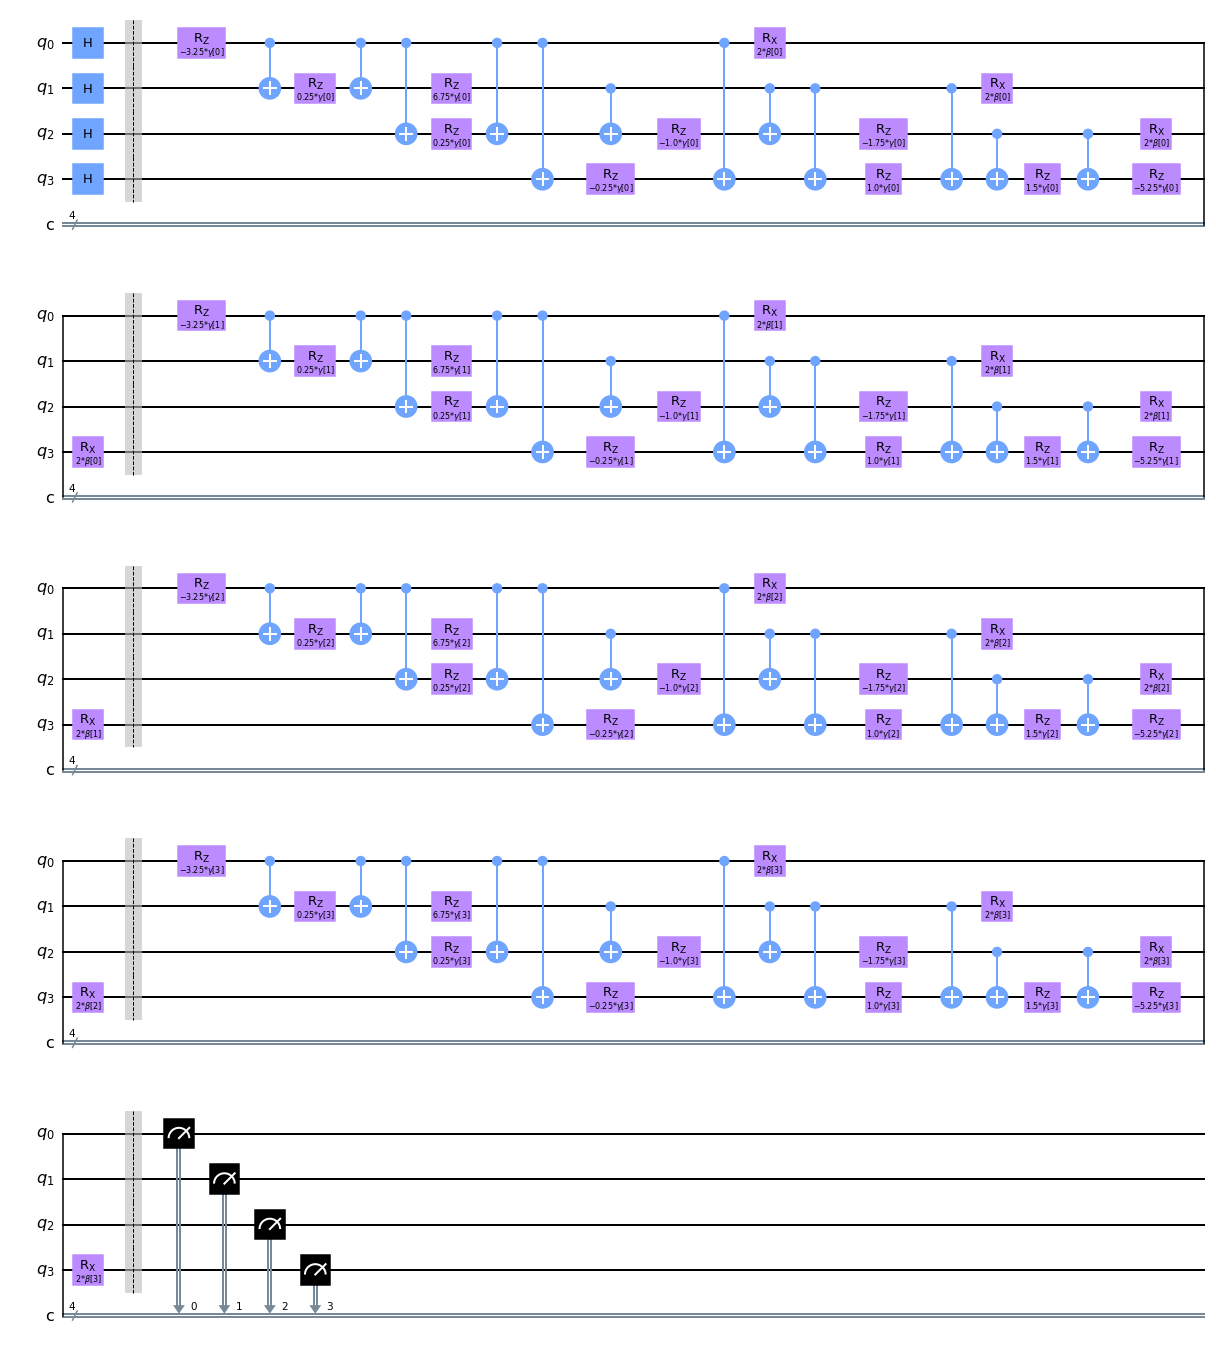

In [107]:
def U_mix(beta):
    
    qc = QuantumCircuit(nvar)
    
    for i in range(nvar):
        qc.rx(2*beta, i)
        
    return qc

#=======================
# Building the circuit
#=======================

# Number of repetitions for U_M, U_C blocks
p = 4

# Parameters to use for the optimization - One for each repetition
# For U_C
gamma = ParameterVector(r'$\gamma$', p)

# For U_M
beta = ParameterVector(r'$\beta$', p)

# Building the circuit where we will combine all unitaries
# Now, it has nvar qubits and nvar classical registers
qaoa_circ = QuantumCircuit(nvar, nvar)

# Preparation of the initial state - Hadamard gates on all qubits
qaoa_circ.h(range(nvar))

# A barrier for better visualization
qaoa_circ.barrier()

# Alternation of the unitaries repeated p times
for rep in range(p):
    pass
    # Application of U_C (without changing the circuit, from the inplace) 
    qaoa_circ.compose(U_cost(c_lin_Hc, c_quad_Hc, gamma[rep]), inplace=True)
    
    # Application of U_M
    qaoa_circ.compose(U_mix(beta[rep]), inplace=True)
    
    qaoa_circ.barrier()
    
# Closing the circuit associating computational basis measurements from each qubit to each register
for i in range(nvar):
    qaoa_circ.measure(i, i)
    
# Drawing the circuit
qaoa_circ.draw('mpl');

---
**Optimization**

Optimal value found - QAOA: 1.7281494140625
Brute force value: 10.0
Brute force sequences: 1011



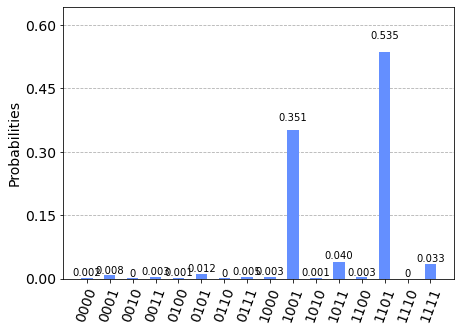

In [109]:
# Backend da IBM onde a computação irá rodar
#   Usaremos um simulador pra não precisar logar no qiskit 
#   e pra rodar sem muitas restrições de tamanho e complexidade
backend = Aer.get_backend('qasm_simulator')

# Número de medições realizadas a cada implementação do circuito
# durante a busca pelos parâmetros ótimos
search_shots = 8192

# Objective function
def objective(var, circ_in, cvar=1):
    ''' Objective function to be used as input in minimize
    var is a 2*p x 1 array containing the values for the parameters gamma (cost Hamiltonian) 
    and beta (mixing Hamiltonian). The first p values correspond to gamma, while the last p 
    correspond to beta
    
    circ_in is the basis circuit with unset values for the parameters. Should be the circuit
    with the sequence for QAOA
    
    cvar is the conditional value at risk, a cutoff to take only a percentile of the best value 
    found in a given run of the experiment.
    
    From the sequences sampled in the experiment, we compute C(x) directly
    We can use cvar < 1 to keep just a fraction of the best results found
    cvar = 0 selects only the best result found, while cvar = 1 selects all sampled values
    Somewhere in between we balance a smooth function and a function that includes only some of the 
    best sequences found.'''
    
    # Building the dictionary to map values in var to the parameters beta and gamma
    var_to_param = {}
    for i in range(p):
        var_to_param[gamma[i]] = var[i]
        var_to_param[beta[i]]  = var[i + p]
    
    # Attributing the values to the parameters and obtaining the circuit with specific values
    eff_circ = circ_in.bind_parameters(var_to_param)
    
    # Running the circuit in the selected backend at IBMQ (or in the local simulated backend)
    # We run the circuit with the specific values and run the measurements a number of times, 
    # given by search_shots. The seed is fixed at 100 for some reproducibility
    counts = execute(eff_circ, backend, seed_simulator = 100, shots=search_shots).result().get_counts()        
    
    # Quantity of different sequences obtained
    # counts is a dictionary that store the qubit sequences measured as its keys
    # and the number of times each sequence was obtained as value
    q_seqs = len(counts.keys())
    
    # An array to store the values for each sequence sampled and the corresponding number of samples
    values = np.zeros((q_seqs, 2))
    
    # Iterating over the sequences found
    for j, k in enumerate(counts.keys()):
        values[j,0] = counts[k]
        
        # Computing C(x) for the given sequence k
        # Note that Qiskit reverses the order of the qubits
        tmp_x = np.array([int(s) for s in k[::-1]])
        
        values[j,1] = c_lin@tmp_x + tmp_x@c_quad@tmp_x
    
    
    if cvar==1:
        # We estimate the average for all values found if cvar is 1
        fcn_val = np.sum(values[:,0]*values[:,1])/np.sum(values[:,0])
        
    elif cvar==0:
        # In case cvar=0, we simply pick the best value found
        fcn_val = np.max(values[:,1])
        
    else:
        # For 0 < cvar < 1
        # Ordering the values found for C(x), for the case when cvar < 1
        tmp_ord = np.argsort(values[:,1])[::-1]
        values = values[tmp_ord,:]
        
        # Converting counts into relative frequencies and making the cut on cvar
        values[:,0] = values[:,0]/np.sum(values[:,0])
        
        tmp_prob = 0
        for j in range(q_seqs):
            if tmp_prob + values[j,0] > cvar:
                break
            else:
                tmp_prob += values[j,0]

        # Taking now the expected value of the best values up to a probability cvar 
        fcn_val = (np.sum(values[:j,0]*values[:j,1]) + (cvar-tmp_prob)*values[j,1])/cvar
        
    # We invert the sign of f to use the minimize routine as a maximizer
    return -fcn_val 


# Initial guess for circuit parameters
# Values follow the same order of the mapping between parameters:
# First p correspond to U_C, last p correspond to U_M
init_guess = np.random.random(size=2*p)
init_guess[:p] *= 2*np.pi
init_guess[p:] *= np.pi

# Finally the optimization. We provide the objective function to scipy.minimize 
# and let it perform its magic
q_result = minimize(objective, init_guess, args=(qaoa_circ), method='COBYLA')

print(f"Optimal value found - QAOA: {-qopt_result['fun']}")

# Comparison with brute force, if the computation has been realized
try:
    print(f'Brute force value: {opt_brute}')
    print(f"Brute force sequences: {'; '.join([s for s in opt_seq])}\n")
except NameError:
    pass

#======================
# Graphing the results 
#======================
# We will run the experiment one more time

# Mapping the values found for the parameters
opt_var = q_result['x']
var_to_param = {}
for i in range(p):
    var_to_param[gamma[i]] = opt_var[i]
    var_to_param[beta[i]]  = opt_var[i + p]

# Getting the counts histogram with optimal parameters
graph_circ = qaoa_circ.bind_parameters(var_to_param)
counts = execute(graph_circ, backend, seed_simulator=100, shots=8192).result().get_counts() 
plot_histogram(counts);